# Model Training Phase 2

This notebook documents Phase 2 of model training for mental health text classification. The classifier is optimized on balanced training data to distinguish suicidal, depressive, anxious, and normal posts. For rigorous evaluation, the model is tested on a newly built test set—created by combining previously mentioned datasets—to ensure results reflect generalization across diverse text sources.


## 1. Environment & Dependency Setup

In [1]:
!pip uninstall -y torch torchvision torchaudio transformers huggingface_hub diffusers gradio pyarrow fsspec websockets numpy pandas
!pip install --upgrade pip
!pip install numpy==1.26.4 pandas==2.2.3 pyarrow==14.0.1 fsspec==2025.3.0
!pip install torch==2.4.1 torchvision==0.19.1 torchaudio==2.4.1 --index-url https://download.pytorch.org/whl/cu126
!pip install transformers==4.45.1 huggingface-hub==0.26.2 datasets==3.0.2 accelerate==1.1.1
!pip install websockets==13.0 emoji textblob sentence-transformers spacy
!python -m spacy download en_core_web_sm
import torch, transformers, datasets, spacy, numpy, pandas
print("All libraries installed successfully!")
print("Torch:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU device:", torch.cuda.get_device_name(0))
print("Transformers:", transformers.__version__)
print("Datasets:", datasets.__version__)
print("SpaCy:", spacy.__version__)
print("NumPy:", numpy.__version__)
print("Pandas:", pandas.__version__)


Found existing installation: torch 2.8.0+cu126
Uninstalling torch-2.8.0+cu126:
  Successfully uninstalled torch-2.8.0+cu126
Found existing installation: torchvision 0.23.0+cu126
Uninstalling torchvision-0.23.0+cu126:
  Successfully uninstalled torchvision-0.23.0+cu126
Found existing installation: torchaudio 2.8.0+cu126
Uninstalling torchaudio-2.8.0+cu126:
  Successfully uninstalled torchaudio-2.8.0+cu126
Found existing installation: transformers 4.57.1
Uninstalling transformers-4.57.1:
  Successfully uninstalled transformers-4.57.1
Found existing installation: huggingface-hub 0.35.3
Uninstalling huggingface-hub-0.35.3:
  Successfully uninstalled huggingface-hub-0.35.3
Found existing installation: diffusers 0.35.2
Uninstalling diffusers-0.35.2:
  Successfully uninstalled diffusers-0.35.2
Found existing installation: gradio 5.49.1
Uninstalling gradio-5.49.1:
  Successfully uninstalled gradio-5.49.1
Found existing installation: pyarrow 18.1.0
Uninstalling pyarrow-18.1.0:
  Successfully un

Looking in indexes: https://download.pytorch.org/whl/cu126
ERROR: Could not find a version that satisfies the requirement torch==2.4.1 (from versions: 2.6.0+cu126, 2.7.0+cu126, 2.7.1+cu126, 2.8.0+cu126, 2.9.0+cu126)
ERROR: No matching distribution found for torch==2.4.1
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 126.7 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 137.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 78.9 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 15.5 MB/s  0:00:25
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 32.0 MB/s  0:00:14
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 176.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 68.8 MB/s  0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 39.8 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 74.8 MB/s  0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 161.0 MB/s  0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
All libraries installed successfully!
Torch: 2.9.0+cu128
CUDA available: True
GPU device: Tesla T4
Transformers: 4.45.1
Datasets: 3.0.2
SpaCy: 3.8.7
NumPy: 2.0.2
Pandas: 2.2.3


In [1]:
from huggingface_hub import login
login(new_session=False)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


## 2. Import Libraries

In [2]:
import time
import datetime
import torch
import pandas as pd
import numpy as np
from google.colab import files
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import matplotlib.pyplot as plt

init_start = time.time()

torch.manual_seed(42)
np.random.seed(42)

print("MODEL TESTING PHASE 2 STARTED")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Torch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"GPU device in use: {torch.cuda.get_device_name(0)}")

print(f"Using device: {device}")

init_end = time.time()
print(f"Initialization completed in {init_end - init_start:.2f} seconds.")

MODEL TESTING PHASE 2 STARTED
Torch version: 2.9.0+cu128
CUDA available: True
GPU device in use: Tesla T4
Using device: cuda
Initialization completed in 0.04 seconds.


## 3. Upload Model and Test Data

In [4]:
def upload_file(description):
    print(f"\n--- Uploading: {description} ---")
    start = time.time()
    uploaded = files.upload()
    print(f"Upload completed in {time.time() - start:.2f} seconds.")
    return uploaded


# Main upload process
overall_start = time.time()
print("Upload Stage Initiated.")

model_file = upload_file("Trained Model Checkpoint")
dataset_file = upload_file("Test Dataset")

print("\nAll required files uploaded successfully.")
print(f"Total Duration: {time.time() - overall_start:.2f} seconds.")

Upload Stage Initiated.

--- Uploading: Trained Model Checkpoint ---


Upload completed in 1.84 seconds.

--- Uploading: Test Dataset ---


Saving mental_health_combined_test.csv to mental_health_combined_test.csv
Upload completed in 31.40 seconds.

All required files uploaded successfully.
Total Duration: 33.28 seconds.


## 4. Load and Prepare Test Data
Loads test dataset from CSV, displays sample records and checks column/row quality for test evaluation.

In [7]:
data_load_start = time.time()
print("Dataset loading initiated.")

TEXT_COL = 'text'
LABEL_COL = 'status'

df_test = pd.read_csv('mental_health_combined_test.csv')
print("Sample test records:")
print(df_test[[TEXT_COL, LABEL_COL]].head())
print(f"Total test samples: {len(df_test)}")

data_load_end = time.time()
print(f"Dataset loading and preview completed in {data_load_end - data_load_start:.2f} seconds.")

Dataset loading initiated.
Sample test records:
                                                text      status
0  I will be free this weekend.I don't know why I...    Suicidal
1  it's almost the end of the 2010's, it was the ...  Depression
2  i'm a programmer who just started working at a...     Anxiety
3  i'm constantly so angry that i have to do all ...  Depression
4  Back again today with the thought of putting a...    Suicidal
Total test samples: 992
Dataset loading and preview completed in 0.03 seconds.


## 5. Label Encoding
Maps string labels to integers consistent with training.

In [8]:
label2id = {'Anxiety': 0, 'Depression': 1, 'Normal': 2, 'Suicidal': 3}
id2label = {v: k for k, v in label2id.items()}

def map_or_identity(label):
    if isinstance(label, str) and label in label2id:
        return label2id[label]
    try:
        if int(label) in id2label:
            return int(label)
    except:
        pass
    return np.nan

mapped = df_test["status"].apply(map_or_identity)
unmapped = df_test[mapped.isnull()]
if not unmapped.empty:
    print("Unmapped labels detected:", unmapped["status"].unique())
    print("These will be dropped. Check your test file for typos if too many are dropped.")

before = len(df_test)
df_test = df_test[mapped.notnull()].copy()
df_test["status"] = mapped[mapped.notnull()].astype(int)
after = len(df_test)
print(f"Dropped {before - after} rows due to unmapped or missing labels.")
print("Encoded test label values:", df_test["status"].unique())


Dropped 0 rows due to unmapped or missing labels.
Encoded test label values: [3 1 0 2]


*Decision Note: 
Unified label encoding is essential for consistent predictions and metric calculation. Dropping unmapped samples eliminates evaluation errors and keeps reporting meaningful*.

In [9]:
print("Test Data Length:", len(df_test))
print("Sample labels in test set:", df_test[LABEL_COL].unique())
print("First 5 samples:", df_test.head())


Test Data Length: 992
Sample labels in test set: [3 1 0 2]
First 5 samples:                                                 text  status
0  I will be free this weekend.I don't know why I...       3
1  it's almost the end of the 2010's, it was the ...       1
2  i'm a programmer who just started working at a...       0
3  i'm constantly so angry that i have to do all ...       1
4  Back again today with the thought of putting a...       3


## 6. Dataset and DataLoader
Defines PyTorch dataset for test data (tokenization, batching), then creates a DataLoader for efficient prediction.

In [10]:
dataset_start = time.time()
print("Dataset preparation initiated.")

class TestDataset(Dataset):
    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df[TEXT_COL].tolist()
        self.labels = df[LABEL_COL].tolist()
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding='max_length',
            truncation=True,
            max_length=self.max_len,
            return_tensors='pt'
        )
        item = {k: v.squeeze(0) for k, v in enc.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.long)
        return item

tokenizer = AutoTokenizer.from_pretrained("mental/mental-bert-base-uncased")
test_ds = TestDataset(df_test, tokenizer)
test_loader = DataLoader(test_ds, batch_size=32, shuffle=False)

dataset_end = time.time()
print("Test DataLoader prepared successfully.")
print(f"Dataset setup completed in {dataset_end - dataset_start:.2f} seconds.")

Dataset preparation initiated.


tokenizer_config.json:   0%|          | 0.00/321 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Test DataLoader prepared successfully.
Dataset setup completed in 1.19 seconds.


/usr/local/lib/python3.12/dist-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


## 7. Load Model
Loads the trained model architecture and checkpoint weights, sets device to GPU/CPU and puts model in evaluation mode.

In [11]:
model_load_start = time.time()
print("Model loading initiated.")

model = AutoModelForSequenceClassification.from_pretrained(
    "mental/mental-bert-base-uncased",
    num_labels=4
)
model.load_state_dict(torch.load('model_phase2.pth', map_location='cpu'))
model.to(device)
model.eval()

model_load_end = time.time()
print("Model successfully loaded and ready for inference.")
print(f"Model setup completed in {model_load_end - model_load_start:.2f} seconds.")

Model loading initiated.


config.json:   0%|          | 0.00/639 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at mental/mental-bert-base-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model successfully loaded and ready for inference.
Model setup completed in 8.39 seconds.


## 8. Inference
Runs batched inference across the test set—collects predicted labels and ground truth labels, times the inference cycle.

In [12]:
inference_start = time.time()
print("Inference process started.")

all_preds, all_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v.to(device) for k, v in batch.items()}
        logits = model(**inputs).logits
        preds = torch.argmax(logits, dim=-1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(inputs['labels'].cpu().numpy())

inference_end = time.time()
print(f"Inference completed in {inference_end - inference_start:.2f} seconds.")

Inference process started.
Inference completed in 6.66 seconds.


## 9. Metrics and Visualization
Calculates accuracy, precision, recall, and macro F1 scores, prints classification report, and plots test set confusion matrix.

Model evaluation started.
Test Accuracy: 0.5464
Macro F1: 0.5137
Macro Precision: 0.6146
Macro Recall: 0.5464

Classification Report:
              precision    recall  f1-score   support

     Anxiety       0.75      0.52      0.61       248
  Depression       0.40      0.62      0.49       248
      Normal       0.58      0.89      0.70       248
    Suicidal       0.73      0.15      0.25       248

    accuracy                           0.55       992
   macro avg       0.61      0.55      0.51       992
weighted avg       0.61      0.55      0.51       992



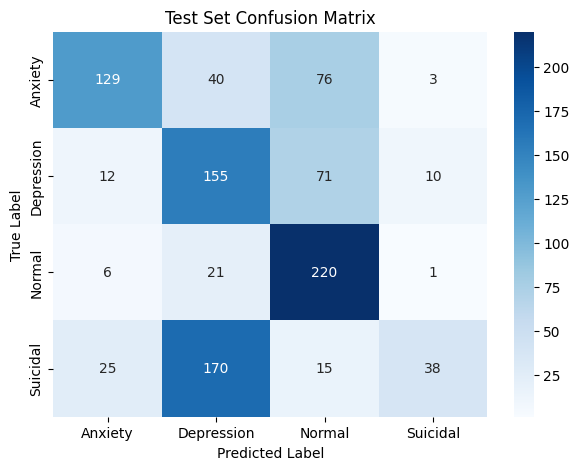

Evaluation and visualization completed in 0.36 seconds.


In [13]:
metrics_start = time.time()
print("Model evaluation started.")

# Safety check: avoid errors with empty lists
if len(all_labels) == 0 or len(all_preds) == 0:
    print("No predictions or labels found for evaluation. Please check your test data and model output.")
else:
    # Accuracy
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # F1, Precision, Recall
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_macro = precision_score(all_labels, all_preds, average='macro')
    recall_macro = recall_score(all_labels, all_preds, average='macro')

    print(f"Macro F1: {f1_macro:.4f}")
    print(f"Macro Precision: {precision_macro:.4f}")
    print(f"Macro Recall: {recall_macro:.4f}")

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(
        all_labels,
        all_preds,
        target_names=[id2label[i] for i in range(4)],
        zero_division=0  # Prevents warnings if no samples in class
    ))

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds, labels=list(range(4))) # Ensures matrix covers all classes
    plt.figure(figsize=(7, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=[id2label[i] for i in range(4)],
        yticklabels=[id2label[i] for i in range(4)],
        cmap='Blues'
    )
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Test Set Confusion Matrix")
    plt.show()

metrics_end = time.time()
print(f"Evaluation and visualization completed in {metrics_end - metrics_start:.2f} seconds.")

*Decision Note: Comprehensive metrics verify real-world model performance. Confusion matrix reveals misclassification patterns and guides further improvements.&*

## Model Inference Summary

Model evaluation indicates moderate performance on the current test set, with an overall test accuracy of \(0.5464\) and a macro F1-score of \(0.5137\). Class-wise results revealed higher precision for Anxiety (\(0.75\)) and Suicidal (\(0.73\)), though Suicidal recall was much lower (\(0.15\)). Normal class predictions showed strong recall (\(0.89\)) but only moderate precision (\(0.58\)), while Depression predictions were more balanced but overall weaker (\(0.40\) precision, \(0.62\) recall).

### Confusion Matrix

- The model predicted the Normal class well but struggled to distinguish Suicidal and Depression samples.
- There was significant confusion between Suicidal and Depression, as indicated by a high number of misclassifications.

### Summary

The model is moderately effective, especially for the Normal and Anxiety classes, but requires substantial improvement for accurate detection of Suicidal and Depression cases. Further training or data balancing is recommended to improve recall and precision for these critical categories.
